In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [18]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')

In [19]:
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [20]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [21]:
train_data.shape

(1258, 6)

In [23]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

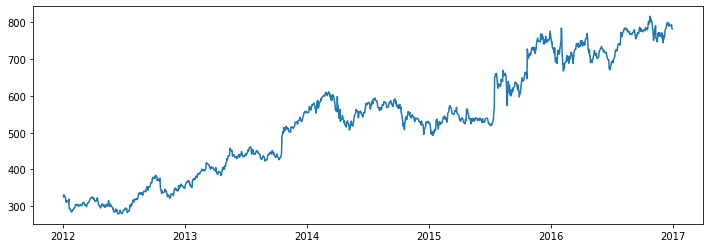

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(train_data['Date'], train_data['Open'])

In [25]:
train_data.corr()

,Open,High,Low
Open,1.000000,0.999692,0.999498
High,0.999692,1.000000,0.999480
Low,0.999498,0.999480,1.000000


In [75]:
# data preprocessing
train = train_data['Open'].values.reshape(-1, 1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train = scaler.fit_transform(train)

# prepare training dataset for 60 timesteps
x_train = []
y_train = []

for i in range(train.shape[0]-60):
    x_train.append(train[i:i+60, 0])
    y_train.append(train[i+60, 0])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], 1))

In [76]:
x_train.shape

(1198, 60, 1)

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import metrics

In [184]:
model = Sequential()

# model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(rate=0.1))

model.add(LSTM(units=70, return_sequences=True))
model.add(Dropout(rate=0.1))

model.add(LSTM(units=70, return_sequences=False))
model.add(Dropout(rate=0.1))

model.add(Dense(units=1))

model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[metrics.mae])

In [185]:
model.fit(x_train, y_train, batch_size=64, epochs=30, verbose=1)

Train on 1198 samples
Epoch 1/30
1198/1198 [==============================] - 7s 6ms/sample - loss: 0.0340 - mean_absolute_error: 0.1175
Epoch 2/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0109 - mean_absolute_error: 0.0808
Epoch 3/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0100 - mean_absolute_error: 0.0752
Epoch 4/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0099 - mean_absolute_error: 0.0767
Epoch 5/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0091 - mean_absolute_error: 0.0740
Epoch 6/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0067 - mean_absolute_error: 0.0592
Epoch 7/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0067 - mean_absolute_error: 0.0611
Epoch 8/30
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0075 - mean_absolute_error: 0.0671
Epoch 9/30
1198/1198 [==============================] - 5s

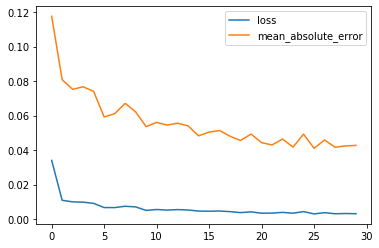

In [186]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [183]:
# hyperparameter tuning
n_trials = 8
epochs = 4

losses = pd.DataFrame()

for i in range(n_trials):
    n = np.random.choice([30, 50, 70])
    r = np.random.choice([0.1, 0.3, 0.5])
    l = np.random.choice([3, 4, 6])
    bs = np.random.choice([32, 64, 128])

    model = Sequential()
    for j in range(l):
        model.add(LSTM(units=n, return_sequences=True))
        model.add(Dropout(rate=r))

    model.add(Dense(units=1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=[metrics.mae])

    model.fit(x_train, y_train, batch_size=bs, epochs=epochs, verbose=1)

    loss = pd.DataFrame(model.history.history)
    print('n={}, r={}, l={}, bs={}'.format(n, r, l, bs))   
    print('loss value at last epoc: {}\n'.format(loss.iloc[-1,0]))
    losses = pd.concat([losses, loss.iloc[-1, :]], axis=1)
    
# losses.idxmin()
# list(range(len()))

Train on 1198 samples
Epoch 1/4
1198/1198 [==============================] - 8s 7ms/sample - loss: 0.0722 - mean_absolute_error: 0.1904
Epoch 2/4
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0353 - mean_absolute_error: 0.1316
Epoch 3/4
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0281 - mean_absolute_error: 0.1172
Epoch 4/4
1198/1198 [==============================] - 4s 3ms/sample - loss: 0.0220 - mean_absolute_error: 0.1014
n=70, r=0.1, l=3, bs=64
loss value at last epoc: 0.021970924543518455

Train on 1198 samples
Epoch 1/4
1198/1198 [==============================] - 7s 6ms/sample - loss: 0.0800 - mean_absolute_error: 0.2027
Epoch 2/4
1198/1198 [==============================] - 5s 4ms/sample - loss: 0.0403 - mean_absolute_error: 0.1443
Epoch 3/4
1198/1198 [==============================] - 5s 4ms/sample - loss: 0.0340 - mean_absolute_error: 0.1304
Epoch 4/4
1198/1198 [==============================] - 5s 5ms/sample - loss: 0.0280 - m

In [206]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

def create_model(l=4, n=50, r=0.1, opt='rmsprop'):
    model = Sequential()
    for j in range(l):
        model.add(LSTM(units=n, return_sequences=True))
        model.add(Dropout(rate=r))
    model.add(Dense(units=1))
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=[metrics.mae])
    return model
    
model = KerasRegressor(build_fn=create_model, epochs=6, batch_size=32)

from sklearn.model_selection import RandomizedSearchCV

parameters = dict(n=[40, 50, 60, 70, 80],
                  r=[0.1, 0.3, 0.5],
                  l=[3, 4, 5, 6],
                  batch_size=[32, 64, 128],
                  opt=['sgd', 'rmsprop', 'adam'])

tuner = RandomizedSearchCV(model, param_distributions=parameters, cv=3, n_iter=10, n_jobs=-1, verbose=1)

In [207]:
tuned_results = tuner.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.0min finished


Train on 1198 samples
Epoch 1/6
1198/1198 [==============================] - 20s 17ms/sample - loss: 0.0530 - mean_absolute_error: 0.1561
Epoch 2/6
1198/1198 [==============================] - 16s 14ms/sample - loss: 0.0271 - mean_absolute_error: 0.1142
Epoch 3/6
1198/1198 [==============================] - 18s 15ms/sample - loss: 0.0185 - mean_absolute_error: 0.0943
Epoch 4/6
1198/1198 [==============================] - 13s 11ms/sample - loss: 0.0153 - mean_absolute_error: 0.0877
Epoch 5/6
1198/1198 [==============================] - 12s 10ms/sample - loss: 0.0134 - mean_absolute_error: 0.0841
Epoch 6/6
1198/1198 [==============================] - 12s 10ms/sample - loss: 0.0109 - mean_absolute_error: 0.0767


In [209]:
# summarize results
print("Best: %f using %s" % (tuned_results.best_score_, tuned_results.best_params_))

means = tuned_results.cv_results_['mean_test_score']
stds = tuned_results.cv_results_['std_test_score']
params = tuned_results.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.013921 using {'r': 0.1, 'opt': 'rmsprop', 'n': 70, 'l': 3, 'batch_size': 32}


In [187]:
test_data = pd.read_csv('Google_Stock_Price_Test.csv')
y_test = test_data['Open'].values.reshape(-1, 1)

total_data = pd.concat([train_data, test_data], axis=0)
total_data = total_data['Open'].values.reshape(-1, 1)

total_data = scaler.transform(total_data)

x_test = []
for i in range(len(test_data)):
    x_test.append(total_data[i-len(test_data)-60:i-len(test_data), 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

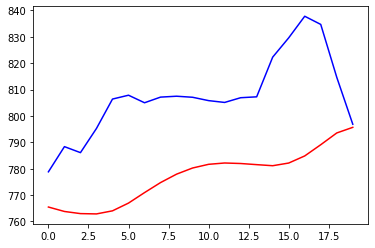

In [188]:
plt.plot(predictions, color='red')
plt.plot(y_test, color='blue')
plt.show()

In [189]:
model.evaluate(x_test, y_test)

20/20 [==============================] - 1s 40ms/sample - loss: 650819.8125 - mean_absolute_error: 806.5995


[650819.8125, 806.5995]

In [190]:
from sklearn.metrics import mean_squared_error
RMSE = round(np.sqrt(mean_squared_error(y_test, predictions)), 2)
print(RMSE)

32.65
